# Import Tensorflow
# Imports Models and layers from keras

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML


In [2]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# connecting Notebook with Drive

In [3]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Define Batch Size , Image size and channels for given Model

In [45]:
BATCH_SIZE = 4
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=20

# Import Dataset from DRIVE
- dataset contains images of normal person  and covid paitient CT SCAN 

In [5]:
"dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Images",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 119 files belonging to 2 classes.


In [6]:
class_names = dataset.class_names
class_names

['COVID', 'Normal']

In [7]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(4, 256, 256, 3)
[0 0 0 0]


# Checking datset and labels for a given Input data

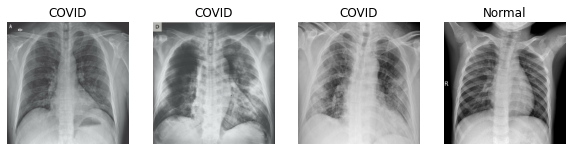

In [8]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(4):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

# Divide data into train test and validation dataset

In [9]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [10]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

# Shuffling the test train and validation dataset

In [11]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# Normalization   of data with min-max scalar

In [12]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1/255),
])

# Apply data augmentaion 
- in order to handle varibality in data
- to avoid overfitting of data

In [13]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.5),
  layers.experimental.preprocessing.RandomZoom(0.5),
])

# building the sequential model and add convolution and pooling layers into the model and then adding dense and output layer into a model

In [14]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 1

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(16, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='sigmoid'),
])

model.build(input_shape=input_shape)

# model Summery"

In [15]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (4, 256, 256, 3)          0         
                                                                 
 sequential_1 (Sequential)   (4, 256, 256, 3)          0         
                                                                 
 conv2d (Conv2D)             (4, 254, 254, 16)         448       
                                                                 
 max_pooling2d (MaxPooling2D  (4, 127, 127, 16)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (4, 125, 125, 64)         9280      
                                                                 
 max_pooling2d_1 (MaxPooling  (4, 62, 62, 64)          0         
 2D)                                                  

# compiling the model

In [16]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

#Fitting the model to the training data and training the model with Epochs

In [17]:

history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=2,
    epochs=10,
)

Epoch 1/10
24/24 - 30s - loss: 0.6176 - accuracy: 0.7684 - val_loss: 0.6456 - val_accuracy: 0.6667 - 30s/epoch - 1s/step
Epoch 2/10
24/24 - 9s - loss: 0.5544 - accuracy: 0.7789 - val_loss: 0.6490 - val_accuracy: 0.6667 - 9s/epoch - 363ms/step
Epoch 3/10
24/24 - 9s - loss: 0.5867 - accuracy: 0.7789 - val_loss: 0.6447 - val_accuracy: 0.6667 - 9s/epoch - 361ms/step
Epoch 4/10
24/24 - 9s - loss: 0.5845 - accuracy: 0.7789 - val_loss: 0.6492 - val_accuracy: 0.6667 - 9s/epoch - 364ms/step
Epoch 5/10
24/24 - 9s - loss: 0.5953 - accuracy: 0.7789 - val_loss: 0.6754 - val_accuracy: 0.6667 - 9s/epoch - 364ms/step
Epoch 6/10
24/24 - 9s - loss: 0.5590 - accuracy: 0.7789 - val_loss: 0.6427 - val_accuracy: 0.6667 - 9s/epoch - 370ms/step
Epoch 7/10
24/24 - 9s - loss: 0.6015 - accuracy: 0.7789 - val_loss: 0.6443 - val_accuracy: 0.6667 - 9s/epoch - 363ms/step
Epoch 8/10
24/24 - 11s - loss: 0.6241 - accuracy: 0.7789 - val_loss: 0.6448 - val_accuracy: 0.6667 - 11s/epoch - 445ms/step
Epoch 9/10
24/24 - 10s 

In [18]:
scores = model.evaluate(test_ds)

3/3 [==============================] - 2s 86ms/step - loss: 0.7106 - accuracy: 0.5455


In [19]:
scores = model.evaluate(test_ds)

3/3 [==============================] - 0s 85ms/step - loss: 0.7106 - accuracy: 0.5455


In [20]:
scores

[0.7105972766876221, 0.5454545617103577]

# printing change in loss for validation and Training data

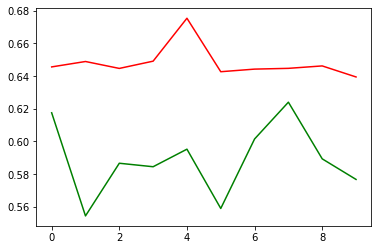

In [21]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure()
plt.plot(loss, color = 'green', label = 'Training Loss')
plt.plot(val_loss, color = 'red', label = 'Validation Loss')

# checking the model accuracy for input image

first image to predict
actual label: COVID
predicted label: COVID


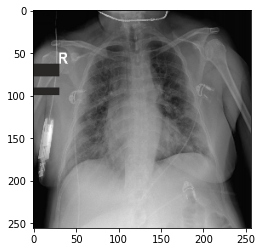

In [23]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

first image to predict
actual label: Normal
predicted label: COVID


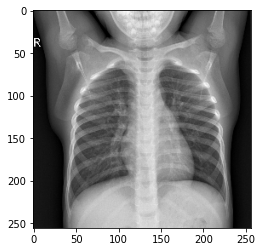

In [24]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[2].numpy().astype('uint8')
    first_label = labels_batch[2].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[2])])

In [25]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

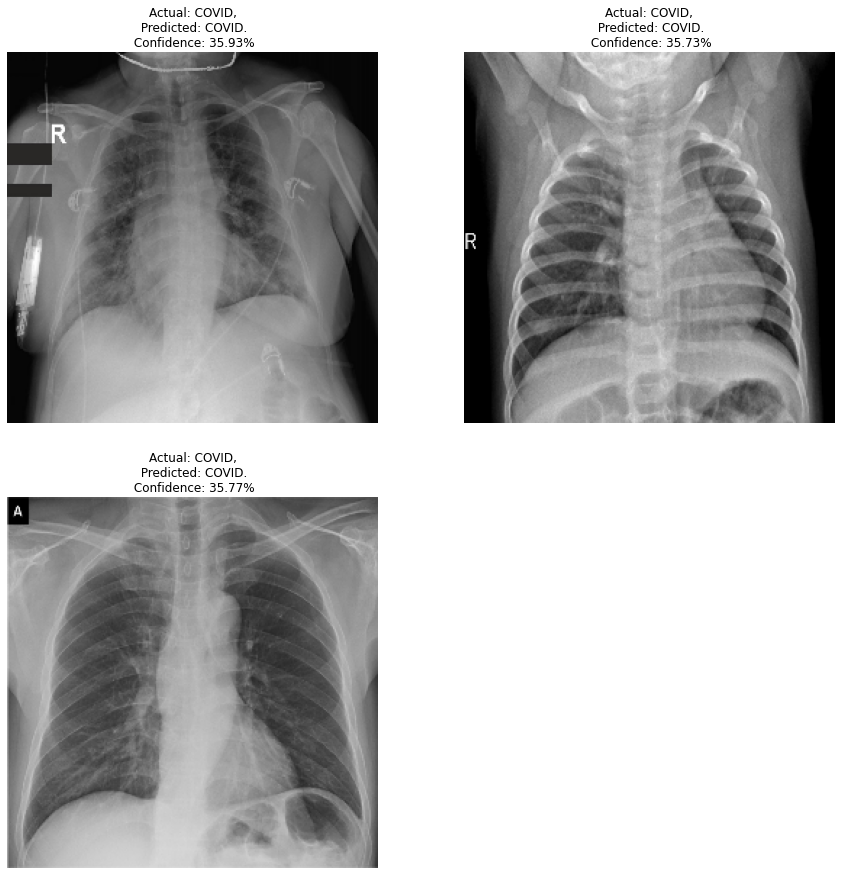

In [26]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(3):
        ax = plt.subplot(2, 2, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [28]:
val_acc

[0.6666666865348816,
 0.6666666865348816,
 0.6666666865348816,
 0.6666666865348816,
 0.6666666865348816,
 0.6666666865348816,
 0.6666666865348816,
 0.6666666865348816,
 0.6666666865348816,
 0.6666666865348816]

In [29]:
acc

[0.7684210538864136,
 0.7789473533630371,
 0.7789473533630371,
 0.7789473533630371,
 0.7789473533630371,
 0.7789473533630371,
 0.7789473533630371,
 0.7789473533630371,
 0.7789473533630371,
 0.7789473533630371]

# printing the validation and test accuracy with respect to the Epochs

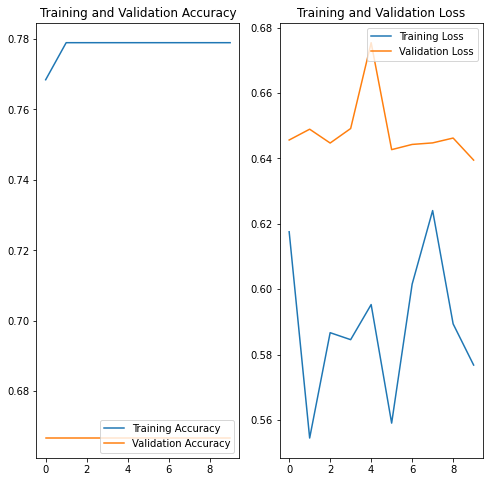

In [30]:
EPOCHS = 10

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# use tranfer learning concept for training the data to improve accuracy of training
- use VGG 19 model for training

In [31]:
model=tf.keras.applications.VGG19()
model.summary()


574726144/574710816 [==============================] - 7s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

# Model Summery for VGG 19 model

In [32]:
vgg19=tf.keras.applications.VGG19(
    include_top=False,
    input_shape=(256,256,3)
)
vgg19.summary()

80150528/80134624 [==============================] - 3s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                              

# Importing model and layers from keras

-  adding dense layers with activation function Relu and for output layer the activation function is Sigmoid
- Print the summery for a model

In [39]:
from tensorflow.keras.layers import Flatten,Dense,Conv2D,MaxPooling2D
model=tf.keras.models.Sequential()
model.add(vgg19)
model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dense(128,activation='relu'))
model.add(Dense(1,activation='sigmoid'))
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 8, 8, 512)         20024384  
                                                                 
 flatten_2 (Flatten)         (None, 32768)             0         
                                                                 
 dense_5 (Dense)             (None, 512)               16777728  
                                                                 
 dense_6 (Dense)             (None, 128)               65664     
                                                                 
 dense_7 (Dense)             (None, 1)                 129       
                                                                 
Total params: 36,867,905
Trainable params: 36,867,905
Non-trainable params: 0
_________________________________________________________________


# compile the model 
- add optimizer function and loss function and print matrics 

In [40]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.build(input_shape=input_shape)

# fit the training data to the model -
# train the model with traing data with number of EPOCHS

In [41]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=2,
    epochs=10,
)

Epoch 1/10
24/24 - 317s - loss: 6044.1855 - accuracy: 0.6947 - val_loss: 0.6827 - val_accuracy: 0.8333 - 317s/epoch - 13s/step
Epoch 2/10
24/24 - 306s - loss: 1.3244 - accuracy: 0.7263 - val_loss: 0.9320 - val_accuracy: 0.3333 - 306s/epoch - 13s/step
Epoch 3/10
24/24 - 304s - loss: 0.7289 - accuracy: 0.6316 - val_loss: 0.6716 - val_accuracy: 0.6667 - 304s/epoch - 13s/step
Epoch 4/10
24/24 - 307s - loss: 0.7726 - accuracy: 0.7053 - val_loss: 0.8966 - val_accuracy: 0.6667 - 307s/epoch - 13s/step
Epoch 5/10
24/24 - 304s - loss: 0.5937 - accuracy: 0.7789 - val_loss: 0.6293 - val_accuracy: 0.6667 - 304s/epoch - 13s/step
Epoch 6/10
24/24 - 306s - loss: 0.5572 - accuracy: 0.7789 - val_loss: 0.6040 - val_accuracy: 0.6667 - 306s/epoch - 13s/step
Epoch 7/10
24/24 - 303s - loss: 0.5136 - accuracy: 0.7789 - val_loss: 0.7625 - val_accuracy: 0.6667 - 303s/epoch - 13s/step
Epoch 8/10
24/24 - 307s - loss: 0.4597 - accuracy: 0.7368 - val_loss: 0.7051 - val_accuracy: 0.6667 - 307s/epoch - 13s/step
Epoch

first image to predict
actual label: COVID
predicted label: COVID


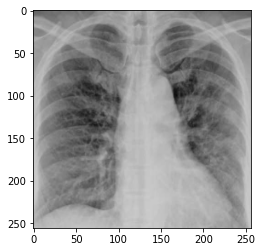

In [42]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[2].numpy().astype('uint8')
    first_label = labels_batch[2].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[2])])

In [43]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# printing  the change in validation and training accuracy with respect to the EPOCHS

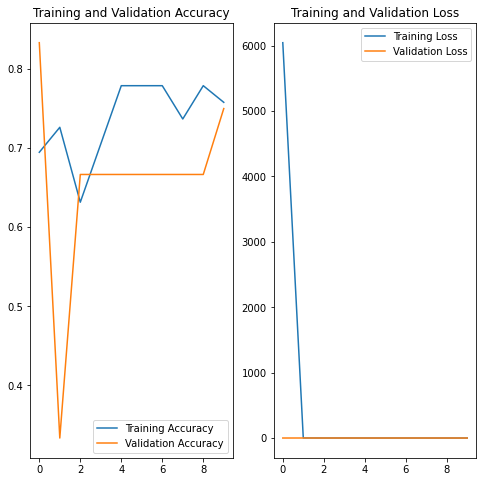

In [44]:
EPOCHS = 10

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Using transfer learning getting better results than previous model